# FMO dynamics simulated with Redfield theory

Setup the Hamiltonian and dynamical model for FMO (see [arXiv:1307](http://arxiv.org/abs/1307.4807)):

In [1]:
import numpy as np
from qspectra import *
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
electronic_fmo = np.array(np.mat("""
    12400 -87.7 5.5 -5.9 6.7 -13.7 -9.9;
    -87.7 12520 30.8 8.2 0.7 11.8 4.3;
    5.5 30.8 12200 -53.5 -2.2 -9.6 6.;
    -5.9 8.2 -53.5 12310 -70.7 -17. -63.3;
    6.7 0.7 -2.2 -70.7 12470 81.1 -1.3;
    -13.7 11.8 -9.6 -17. 81.1 12620 39.7;
    -9.9 4.3 6. -63.3 -1.3 39.7 12430
    """))

dipoles_fmo = np.array([d / np.linalg.norm(d) for d in
    np.array([[3.019, 3.442, 0.797, 3.213, 2.969, 0.547, 1.983],
              [2.284, -2.023, -3.871, 2.145, -2.642, 3.562, 2.837],
              [1.506, 0.431, 0.853, 1.112, -0.661, -1.851, 2.015]]).T])

fmo_hamiltonian = ElectronicHamiltonian(electronic_fmo,
                                        bath=DebyeBath(CM_K * 77, 35, 106),
                                        dipoles=dipoles_fmo,
                                        disorder=100)
dynamical_model = RedfieldModel(fmo_hamiltonian, hilbert_subspace='gef', unit_convert=CM_FS)

## Excited state dynamics

Simulate dynamics in the 1-excitation subspace starting on site 1 for 100 ps:

In [4]:
%time t, rho = simulate_dynamics(dynamical_model, [1,0,0,0,0,0,0], 100000)

CPU times: user 3.4 s, sys: 182 ms, total: 3.58 s
Wall time: 4.56 s


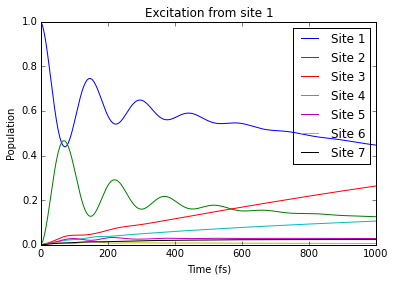

In [5]:
plt.title('Excitation from site 1')
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 7, 7)).real)
plt.xlim(0, 1000)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.legend(['Site {}'.format(n) for n in xrange(1, 8)]);

The long-time evolution indeed approaches thermal equilibrium:

In [6]:
print np.diag(ket_vec_to_matrix(rho[-1])).real

import scipy
def thermal_state(hamiltonian, temperature):
    rho = scipy.linalg.expm(-hamiltonian.in_rotating_frame().H_1exc / temperature)
    return rho / np.trace(rho)

print np.diag(thermal_state(fmo_hamiltonian, CM_K * 77)).real

[ 0.02394464  0.01493232  0.68821011  0.22268562  0.02374941  0.00193277
  0.02454513]
[ 0.02408245  0.0149764   0.68788931  0.22268262  0.02380367  0.00195459
  0.02461096]


## Gaussian pump pulse

Simulate dynamics for an x-polarized Gaussian pump pulse centered at 800nm with a 50fs FWHM:

In [7]:
%%time
pump = GaussianPulse(12500, 50, scale=1e-3, freq_convert=CM_FS)
t, rho = simulate_pump(dynamical_model, pump, 'x', 5000)

CPU times: user 574 ms, sys: 49.2 ms, total: 624 ms
Wall time: 1.16 s


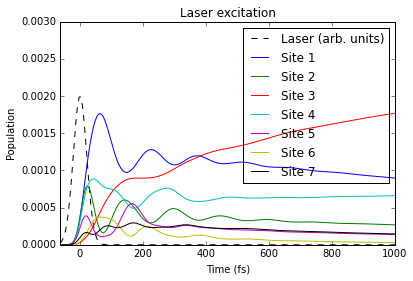

In [8]:
plt.title('Laser excitation')
plt.plot(t, 2 * pump(t, 12500).real, 'k--')
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 8, 8)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(pump.t_init, 1000)
plt.legend(np.concatenate([['Laser (arb. units)'], ['Site {}'.format(n) for n in xrange(1, 8)]]));

## Absorption spectra

In [9]:
%time f, X = absorption_spectra(dynamical_model, 2000, exact_isotropic_average=True)
%time f, X2 = absorption_spectra(dynamical_model, 2000, exact_isotropic_average=True, ensemble_size=5)

CPU times: user 213 ms, sys: 45.3 ms, total: 258 ms
Wall time: 444 ms
CPU times: user 12.7 s, sys: 813 ms, total: 13.5 s
Wall time: 17.8 s


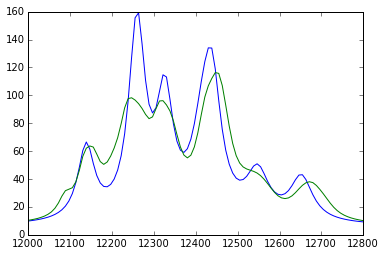

In [11]:
plt.plot(f, X)
plt.plot(f, X2)
plt.xlim(12000, 12800);

## Pump-probe spectra

Pump-probe signal decomposed into a sum of ground-state-bleach (GSB), excited-state-emission (ESE) and excited-state-absorption (ESA) contributions. Uses the final state `rho` from simulation of the Gaussian pump pulse above. 

In [12]:
%%time
X = {}
for signal in ['GSB', 'ESE', 'ESA']:
    f, X[signal] = impulsive_probe(dynamical_model, rho[-1], 5000, 'xx', include_signal=signal)

CPU times: user 601 ms, sys: 66 ms, total: 667 ms
Wall time: 1.34 s


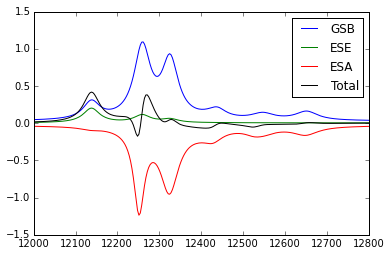

In [13]:
plt.plot(f, X['GSB'].real, 'b-')
plt.plot(f, X['ESE'].real, 'g-')
plt.plot(f, X['ESA'].real, 'r-')
plt.plot(f, np.sum(X.values(), 0).real, 'k-')
plt.legend(['GSB', 'ESE', 'ESA', 'Total'])
plt.xlim(12000, 12800);

In [14]:
%%time
f, X = impulsive_probe(dynamical_model, rho, 5000, 'xx',
                       exact_isotropic_average=True, include_signal='ESE')

CPU times: user 1.11 s, sys: 225 ms, total: 1.33 s
Wall time: 3.67 s


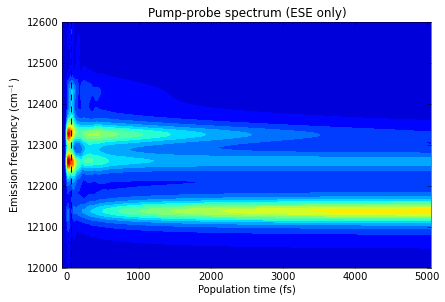

In [13]:
plt.title('Pump-probe spectrum (ESE only)')
plt.contourf(t, f, X.real.T, 20)
plt.plot([pump.t_final, pump.t_final], [12000, 12600], 'k--')
plt.ylim(12000, 12600)
plt.xlabel('Population time (fs)')
plt.ylabel('Emission frequency (cm$^{-1}$)');